In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### 파라미터 지정
- 모델의 입력과 데이터셋의 차원을 지정한다.(이게 있으면 어떤 입력이든 가능하겠네!!!)

In [ ]:
img_rows = 28 
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100 # 잡음 벡터 크기를 100으로 준다 값이 100개 있는 벡터

# 생성자 구현

1. 리키렐루 사용 : 렐루보다 향상시키는 경향(어떤 책이든 리키렐루를 먼저 쓰네)
2. 출력층은 tanh : -1, 1범위로 조정하는게 0, 1의 시그모이드보다 조금 더 또렷한 이미지를 만듬
3. z 벡터를 입력받아 28 * 28 * 1 크기 이미지를 생성한다 따라서 img_shape와 z_dim을 파라미터로 가짐

In [ ]:
def build_generator(img_shape, z_dim):
  model = Sequential()

  model.add(Dense(128, input_dim = z_dim)) # 인풋은 100 다음은 128개의 노드
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Dense(28 * 28 * 1, activation="tanh")) # 128개의 노드 다음은 784개의 노드
  
  # ★생성자 출력을 이미지 차원으로 변경 784를 28 * 28 * 1로 변경★
  model.add(Reshape(img_shape)) 

  return model

# 판별자 구현
1. 28 * 28 * 1의 크기의 이미지를 받아 가짜와 비교
2. 출력은 시그모이드로 0 또는 1로 입력을 진짜로 생각하는 확률을 해석하도록 함

In [ ]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape = img_shape)) # 이미지 모양대로 입력받아서 폄
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation="sigmoid"))

  return model

# GAN 모델 생성
- 앞서 구현한 생성자와 판별자를 add함

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model



- 판별기 생성 함수를 구현
- 생성기 생성 함수를 구현
- gan 생성 함수를 구현(이때 판별기와 생성기를 인자로 받음)
- 판별기와 생성기를 함수로 생성
- gan을 함수로 생성
<br><br><br><br><br>

### 여기서 첫걸음과 다른 점
- 첫걸음은 판별기의 train, 생성기의 train이 따로 있어서 GAN이라는게 판별기 train 두번(실제 가짜), 생성기 train 한번이었지 gan 함수나 클래스가 따로 있지 않았음


- 근데 여기서는 train이 하나고 gan 모델이 생성기와 판별기를 붙여서 훈련을 한 번만 시킨다.

In [ ]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy", # 맞다 아니다
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False # 생성자를 훈련하는 동안 판별자가 훈련되지 않도록 동결 
# -> 참 신기한게  train 함수에 생성자, 판별자 생성을 넣은 것도 아니고 .trainable = False를 밖에서 그냥 한 건데 훈련시 동결이 된대 이게 라이브러리 메소드의 힘이다!!

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = [] #이건 그저 손실을 그래프로 그리긴 위한 배열
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정 ∵ 생성자의 끝이 tanh라서 판별자의 모든 입력 범위를 맞춰야함
    X_train = X_train / 127.5 - 1.0 # -> 0 / 127.5 = 0 > 0-1 = '-1'/ 255 / 127.5 = 2 > 2-1 = '1'


    X_train = np.expand_dims(X_train, axis=3) #60000, 28, 28, 1

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        # np.random.randint(최소값, 미만값, size) - 랜덤한 정수 추출
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0 ~ 60000 사이의 수에서 128개의 수를 뽑음
        imgs = X_train[idx] # 그것을 fancy 인덱싱하면 랜덤으로 뽑은 수(행)에 해당하는 mnist 이미지가 생김








        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100)) #0~1수 128행 100열을 만듬
        gen_imgs = generator.predict(z) #이게 왜 되지? -> 시퀀셜 모델일 뿐이니 predict 인정 model.predict임

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real) # 이게 케라스 라이브러임 fit과 같은 거임 와,,,,

        # gen_imgs는 어딨음? 밑에 있음 ㅋㅋ
        # 보다시키 train은 하나지만 d를 두번 훈련하고 그때 실제 데이터에는 1 가짜에는 0을 주는 것은 첫걸음과 동일
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) 
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)





        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지에 넣을 크기 100(z_dim = 100차원)의 벡터를 생성
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real) # 생성자는 가짜가 1이라고 말함 -> gan으로 하는 이유는 생성자는 판별자도 필요함 = 판별자의 오차로 생성자를 훈련하니


        # 훈련 과정 그리기위한 것 = 에폭 2의 백수이면 정확도와 손실을print하라
        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4/4 [==============================] - 0s 4ms/step
3000 [D 손실: 0.086750, 정확도: 96.09%] [G 손실: 5.657326]
4/4 [==============================] - 0s 4ms/step
4000 [D 손실: 0.306640, 정확도: 89.06%] [G 손실: 3.800500]
4/4 [==============================] - 0s 6ms/step
5000 [D 손실: 0.134476, 정확도: 95.70%] [G 손실: 4.904284]
1/1 [==============================] - 0s 24ms/step


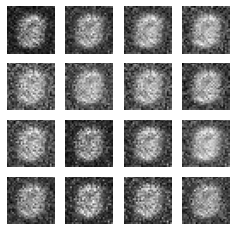

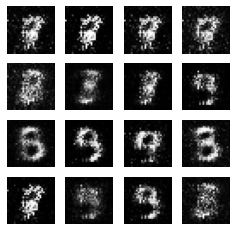

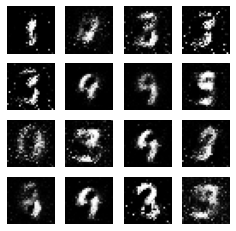

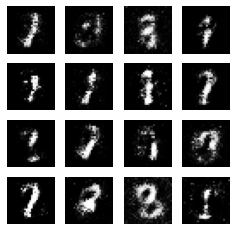

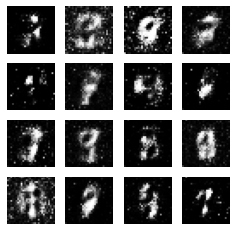

In [ ]:
# 하이퍼파라미터 설정
iterations = 5000
batch_size = 128
sample_interval = 1000 # 1000에폭에 저장해라

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval)

# test 해보자!!!
-> 여기서 테스트란 정확도나 그런게 아니다 latent vector를 넣었는데 실제 이미지 같은 가짜이미지가 나오나이다.


-> 가장 중요한게 훈련은 판별자와 생성자 같이 시키는데 나중에는 생성자만 쓰는 거 알지?? 그것이 위의 sample images 메소드에 담겨있다.

In [ ]:
z = np.random.normal(0, 1, 100)

In [ ]:
z.shape

(100,)

In [ ]:
z = np.random.normal(0, 1, (1, z_dim))

# 랜덤한 잡음에서 이미지 생성하기
gen_imgs = generator.predict(z)

# 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
gen_imgs = 0.5 * gen_imgs + 0.5

1/1 [==============================] - 0s 20ms/step


In [ ]:
type(gen_imgs)

numpy.ndarray

In [ ]:
gen_imgs.shape

(1, 28, 28, 1)

In [ ]:
# 안되네..?
# gen_imgs.reshape(28, 28)
# gen_imgs.shape

In [ ]:
gen_imgs = np.squeeze(gen_imgs, axis=0)
gen_imgs.shape

(28, 28, 1)

TypeError: ignored

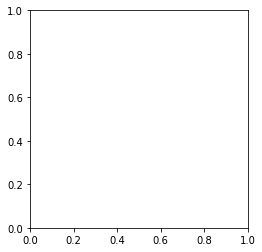

In [ ]:
plt.imshow(gen_imgs)

In [ ]:
gen_imgs = gen_imgs / 255.0
gen_imgs.shape

(28, 28, 1)

TypeError: ignored

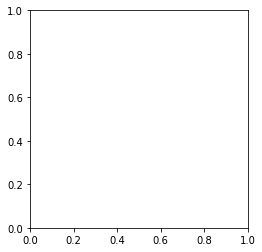

In [ ]:
plt.imshow(gen_imgs)

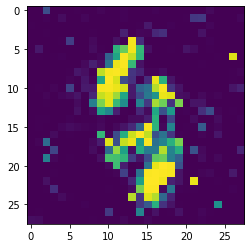

In [ ]:
 # 28 * 28 * 1은 28 * 28로 넣어야하네~
 plt.imshow(np.squeeze(gen_imgs))